In [1]:
import pandas as pd
import sqlalchemy 
import psycopg2
import os
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import datetime as dt

In [2]:
#guardar paso en csv
path='/data/ETLcache/'
now = dt.now()
timestamp = now.strftime("_%d%m%Y_%H%M%S")

In [3]:
DBname=os.environ['DB_NAME']
postgres_psswd=os.environ['POSTGRES_PASSWORD']
postgres_user=os.environ['POSTGRES_USER']
postgres_port=str(os.environ['POSTGRES_PORT'])
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://'+postgres_user+':'+postgres_psswd+'@'+DBname+':'+postgres_port+'/superset')
# Create the connection
cnx = create_engine(postgres_str)

In [4]:
url='https://docs.google.com/spreadsheets/d/1mLx2L8nMaRZu0Sy4lyFniDewl6jDcgnxB_d0lHG-boc/export?gid=1456422453&format=csv'

In [5]:
muertes=pd.read_csv(url,header=[1],encoding='utf-8')
muertes['Fecha']=muertes['Fecha']+'/2020'
muertes['Fecha']=pd.to_datetime(muertes['Fecha'],errors='coerce').dt.to_pydatetime()
muertes=muertes.rename(columns={
    
    'Muertes COVID U07.1':'ConfirmadosPCR+',
    'Muertes Covid Hospitales según SOCHIMI et al.':'SOCHIMI',
    'Muertes COVID U07.2':'DEIS'

})
fecha=muertes['Fecha']
muertes=muertes[['ConfirmadosPCR+','SOCHIMI','DEIS']]
muertes['SOCHIMI']=muertes['SOCHIMI']+muertes['ConfirmadosPCR+']
muertes['DEIS']=muertes['DEIS']+muertes['ConfirmadosPCR+']
muertes_cumsum=muertes.cumsum()
muertes_cumsum.columns=[str(col) + '_TOT' for col in muertes_cumsum.columns]

In [6]:
muertes_log=np.log(muertes+0.0001)
muertes_log[muertes_log<1]=0
muertes_log.columns=['LOG('+str(col) + ')' for col in muertes_log.columns]

In [7]:
muertes_cumsum_log=np.log(muertes_cumsum+0.0001)
muertes_cumsum_log[muertes_cumsum_log<1]=0
muertes_cumsum_log.columns=['LOG('+str(col) + ')' for col in muertes_cumsum_log.columns]

In [8]:
muertes=pd.concat([fecha,muertes,muertes_log,muertes_cumsum,muertes_cumsum_log],axis=1)

In [9]:
def regression(_df,term1='LOG',term2='_TOT'):
    dfm=_df.copy()
    
    
    logs=[x for x in dfm.columns if term1 in x]
    X=[x for x in logs if term2 in x]
    Y=[y for y in logs if term2 not in y]
    
    for x,y in zip(X,Y):
        df=dfm[[x,y]]
        #print(df)
        df=df.replace(0,np.nan)
        df=df.replace([np.inf, -np.inf], np.nan)
        df=df.dropna()
        
        _X=df[x].values.reshape(-1, 1)
        _y=df[y].values.reshape(-1, 1)
        linear_regressor = LinearRegression()
        linear_regressor.fit(_X, _y)
        Y_pred = linear_regressor.predict(dfm[x].values.reshape(-1, 1))
        
        name=x+'_Regress'
        
        dfm[name]=Y_pred
        
    return dfm

In [10]:
pop=pd.read_sql_table('producto1_Covid_19', schema='producto1',con=cnx) 
pop=pop.groupby('Region')['Poblacion'].sum()
popTOT=pop.sum()

In [11]:
muertesMM=(muertes[['ConfirmadosPCR+_TOT','SOCHIMI_TOT','DEIS_TOT']]/popTOT*1000000).round(decimals=2)
muertesMM.columns=[col.replace('_TOT','_MM') for col in muertesMM.columns]

In [12]:
muertesMM_LOG=np.log(muertesMM+0.0001)
muertesMM_LOG[muertesMM_LOG<1]=0
muertesMM_LOG.columns=['LOG('+str(col) + ')' for col in muertesMM_LOG.columns]

In [13]:
muertes=pd.concat([muertes,muertesMM,muertesMM_LOG],axis=1)
muertes=muertes.fillna(0)
muertes = muertes.loc[:,~muertes.columns.duplicated()]

In [14]:
muertes=regression(muertes,term1='LOG',term2='_TOT')

In [15]:
muertes=regression(muertes,term1='LOG',term2='_MM')

In [16]:
def log_log_plot(df,x='',y='',z='',xlabel='',ylabel='',x_label='',y_label='',title='',ax=''):
    
    if ax!='':
        ax = sns.lineplot(x=x, y=y, data=df,marker="o",ax=axes[ax])
        ax = sns.lineplot(x=x, y=z, data=df,ax=axes[ax])
    else:
        ax = sns.lineplot(x=x, y=y, data=df,marker="o")
        ax = sns.lineplot(x=x, y=z, data=df)        
    x_ticks=df[x].dropna().iloc[::30]
    if xlabel=='Fecha':
        x_labels=df.loc[x_ticks.index,xlabel].dt.strftime('%Y-%m-%d')
    else:
        x_labels=df.loc[x_ticks.index,xlabel]
    y_ticks=df[y].dropna().iloc[::30]
    y_labels=df.loc[y_ticks.index,ylabel]
    ax.set(xticks=x_ticks,yticks=y_ticks,xlabel=x_label,ylabel=y_label,title=title)
    ax.set_xticklabels(x_labels, rotation='vertical', fontsize=9)
    ax.set_yticklabels(y_labels, fontsize=9)
    filename=path+title.replace(' ','_').replace('ó','o')+'.png'
    print('saving to file: '+filename)
    plt.savefig(filename)
    backup=path+title.replace(' ','_').replace('ó','o')+timestamp+'.png'
    print('saving backup: '+backup)
    plt.savefig(backup)
    plt.show()

In [17]:
params=[{'x':'LOG(DEIS_TOT)','y':'LOG(DEIS)','z':"LOG(DEIS_TOT)_Regress",'xlabel':'Fecha','ylabel':'DEIS',
             'x_label':'Fecha','y_label':'Muertes Diarias','title':'Muertes DEIS'},
{'x':'LOG(SOCHIMI_TOT)','y':'LOG(SOCHIMI)','z':"LOG(SOCHIMI_TOT)_Regress",'xlabel':'Fecha','ylabel':'SOCHIMI',
             'x_label':'Fecha','y_label':'Muertes Diarias','title':'Muertes SOCHIMI'},
{'x':'LOG(ConfirmadosPCR+_TOT)','y':'LOG(ConfirmadosPCR+)','z':"LOG(ConfirmadosPCR+_TOT)_Regress",'xlabel':'Fecha','ylabel':'ConfirmadosPCR+',
             'x_label':'Fecha','y_label':'Muertes Diarias','title':'Muertes ConfirmadosPCR+'}]

In [18]:
params2=[{'x':'LOG(DEIS_MM)','y':'LOG(DEIS)','z':"LOG(DEIS_MM)_Regress",'xlabel':'DEIS_MM','ylabel':'DEIS',
             'x_label':'Muertes por Millón Hab.','y_label':'Muertes Diarias','title':'Muertes por Millón Hab. DEIS'},
{'x':'LOG(SOCHIMI_MM)','y':'LOG(SOCHIMI)','z':"LOG(SOCHIMI_MM)_Regress",'xlabel':'SOCHIMI_MM','ylabel':'SOCHIMI',
             'x_label':'Muertes por Millón Hab.','y_label':'Muertes Diarias','title':'Muertes por Millón Hab. SOCHIMI'},
{'x':'LOG(ConfirmadosPCR+_MM)','y':'LOG(ConfirmadosPCR+)','z':"LOG(ConfirmadosPCR+_MM)_Regress",'xlabel':'ConfirmadosPCR+_MM','ylabel':'ConfirmadosPCR+',
             'x_label':'Muertes por Millón Hab.','y_label':'Muertes Diarias','title':'Muertes por Millón Hab. ConfirmadosPCR+'}]

saving to file: /data/ETLcache/Muertes_DEIS.png
saving backup: /data/ETLcache/Muertes_DEIS_21082020_082053.png


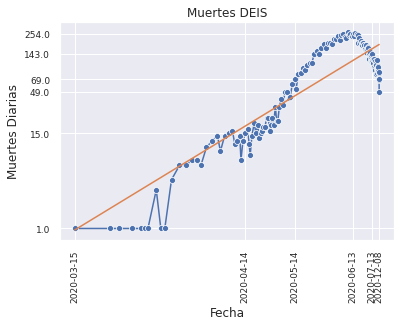

saving to file: /data/ETLcache/Muertes_SOCHIMI.png
saving backup: /data/ETLcache/Muertes_SOCHIMI_21082020_082053.png


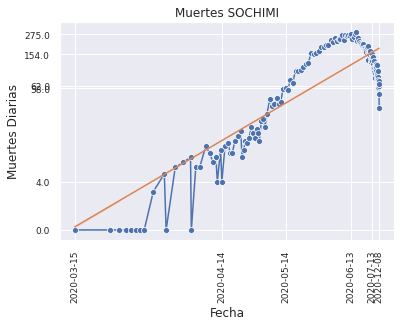

saving to file: /data/ETLcache/Muertes_ConfirmadosPCR+.png
saving backup: /data/ETLcache/Muertes_ConfirmadosPCR+_21082020_082053.png


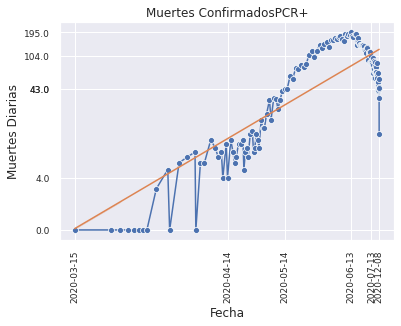

In [19]:
for p in params:
    log_log_plot(muertes,**p)

saving to file: /data/ETLcache/Muertes_por_Millon_Hab._DEIS.png
saving backup: /data/ETLcache/Muertes_por_Millon_Hab._DEIS_21082020_082053.png


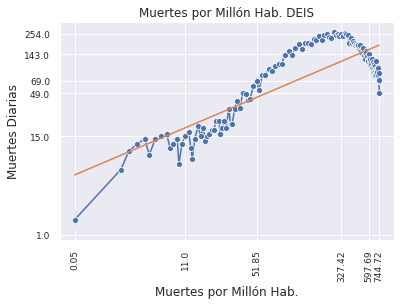

saving to file: /data/ETLcache/Muertes_por_Millon_Hab._SOCHIMI.png
saving backup: /data/ETLcache/Muertes_por_Millon_Hab._SOCHIMI_21082020_082053.png


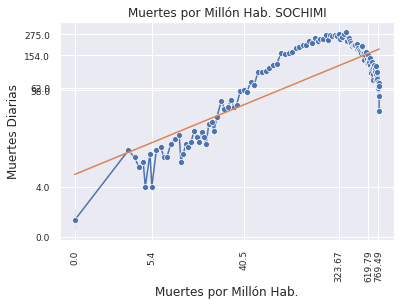

saving to file: /data/ETLcache/Muertes_por_Millon_Hab._ConfirmadosPCR+.png
saving backup: /data/ETLcache/Muertes_por_Millon_Hab._ConfirmadosPCR+_21082020_082053.png


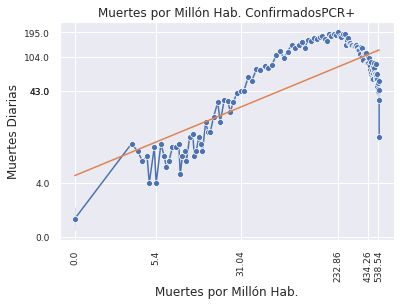

In [20]:
for p in params2:
    log_log_plot(muertes,**p)